### Import Modules

In [692]:
# To plot learning curve graph
%matplotlib inline
import matplotlib.pyplot as plt

# for pretty print
from pprint import pprint

# for tokenizer
import re

# for word counter in vocabulary dictionary
from collections import Counter

# for checkpoint paths
import os

# for fancy progress bar
from tqdm import tqdm

# TensorFlow
import tensorflow as tf

# for output_projection
from tensorflow.python.layers.core import Dense

# for initial attention (not required ver1.2+)
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors

import os
import numpy as np

### Sample training data

In [693]:
path = 'eq_images/cropped'
files = list(set(os.listdir(os.path.join(path,'images'))) - set(['.DS_Store']))
imbeds = list(set(os.listdir('imbeddings2')) - set(['.DS_Store']))

In [694]:
with open(os.path.join(path, '/Users/user/eecs/Deep_Learning/im2latex/im2latex_train.lst')) as fl:
    ids = fl.readlines()
    

In [695]:
id_name_pairs = [(id_[:-1].split())[:-1] for id_ in ids]
imbed2id = dict([(name+'.npy',int(id_)) for id_, name in id_name_pairs])
im2id = dict([(name+'.png',int(id_)) for id_, name in id_name_pairs])

In [696]:
with open('/Users/user/eecs/Deep_Learning/im2latex/im2latex_formulas.lst','rb') as f:
    eqs = f.readlines()

In [697]:
eqs = np.array(eqs)

In [698]:
train_eqs = eqs[list(map(imbed2id.get,imbeds))]

In [699]:
choice = np.random.randint(0,len(files))
choice

40006

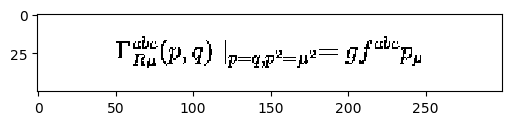

In [700]:
plt.imshow(plt.imread(os.path.join(path,'images',imbeds[choice][:-4]+'.png')))

In [701]:
train_eqs[choice]

b'\\Gamma _{R\\mu }^{abc}(p,q)\\mid _{p=q,p^2=\\mu ^2}=gf^{abc}p_\\mu\n'

In [702]:
from nltk.tokenize import RegexpTokenizer

def tokenizer(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    if type(sentence) is not str:
        sentence = sentence.decode()
    return tokenizer_.tokenize(sentence)

# Example
tokenizer("xy")

['x', 'y']

In [703]:
from nltk.tokenize import RegexpTokenizer
import re

def replace_label(sentence):
    if type(sentence) is not str:
        sentence = sentence.decode()
    return re.sub(string=sentence,
                      pattern=r'\\label\{[^\}]+\}',
                      repl='')


def tokenizer_no_label(sentence):
    tokenizer_ = RegexpTokenizer('\\\\[A-Za-z]+|\\\\\S|\[A-Za-z]+|\d|\S')
    sentence = replace_label(sentence)
    return tokenizer_.tokenize(sentence)

# Example
tokenizer_no_label("xy \\label{this is a label} + z")

['x', 'y', '+', 'z']

In [704]:
def get_length(eq):
    try:
        return len(tokenizer_no_label(eq))
    except:
        return np.inf

Be lazy and retain a multiple of 128 for quick batching without iterators and generators

In [705]:
num_ex= 128*(len(imgs)//128)
num_ex

32128

In [706]:
import pickle

In [707]:
def get_data():
    try:
        with open('data.pkl','rb') as f:
            print('Loading...')
            data = pickle.load(f)
        return data

    except FileNotFoundError:
        print('Creating...')
        from sklearn.model_selection import train_test_split
        data = train_test_split(imbeds, train_eqs, test_size=0.2)
        with open('data.pkl' ,'wb') as f:
            pickle.dump(data, f)
        return data

In [708]:
x_tr, x_val, y_tr, y_val = get_data()

imgs = [np.load(os.path.join('imbeddings2',imbed)) for imbed in x_tr]
batch_size = 128

target_batches = [y_tr[i:i+batch_size] for i in range(0,len(y_tr),batch_size)]
input_batches = [imgs[i:i+batch_size] for i in range(0,len(x_tr),batch_size)]

all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)


Loading...


### NLP helper functions

In [711]:
from collections import defaultdict

In [712]:
def build_vocab(sentences, max_vocab_size=None, verbose = False):
    word_counter = Counter()
    vocab = defaultdict(int)
    reverse_vocab = dict()
    
    for sentence in sentences:
        try:
            tokens = tokenizer_no_label(sentence)
            word_counter.update(tokens)
        except:
            if verbose:
                print(sentence)
            continue
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)

    vocab['_GO'] = 2
    vocab['_PAD'] = 1
    vocab_idx = 3
    for key, value in word_counter.most_common(max_vocab_size):
        vocab[key] = vocab_idx
        vocab_idx += 1
        
    for key, value in vocab.items():
        reverse_vocab[value] = key
    
    reverse_vocab[0] = '_UNK'
    
    return vocab, reverse_vocab, max_vocab_size


In [713]:
# enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences)

# print('input vocabulary size:', enc_vocab_size)
print('target vocabulary size:', dec_vocab_size)


target vocabulary size: 481


In [714]:
def token2idx(word, vocab):
    return vocab[word]

# for token in tokenizer_no_label('V = \\frac{1}{3} \\label{1} \\pi r^2 h'):
#     print(token, token2idx(token, dec_vocab))

In [715]:
dec_sentence_length = 50

In [716]:
def sent2idx(sent, vocab, max_sentence_length, verbose=False):
    try:
        tokens = tokenizer_no_label(sent)[:max_sentence_length]
    except:
        if verbose:
            print(sent)
        tokens = ['_PAD']*max_sentence_length
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    return [1] + [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length
#     else:
#         return [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length

# Enc Example
# print('Hi What is your name?')
# print(sent2idx('Hi What is your name?'))

# Dec Example
print('V = \\frac{1}{3}\\label{label}\\pi r^2 h')
print(sent2idx('V = \\frac{1}{3}\\label{label}\\pi r^2 h', vocab=dec_vocab, max_sentence_length=dec_sentence_length))

V = \frac{1}{3}\label{label}\pi r^2 h
([1, 81, 9, 18, 4, 12, 3, 4, 41, 3, 50, 25, 6, 10, 95, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 14)


In [717]:
def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab, replace_pad = True):
    sent = " ".join([idx2token(idx, reverse_vocab) for idx in indices])
    if replace_pad:
        return sent.replace(' _PAD','')
    return sent

### Hyperparameters / Path

In [718]:
h,w,_ = input_batches[0][0].shape
h,w

(6, 37)

In [719]:
len(dec_reverse_vocab)

484

In [720]:
class DemoConfig:
    
    # Model
    hidden_size = 256
    dec_emb_size = 500 #len(dec_reverse_vocab)
    dec_sent_length = 50
    enc_emb_size = 256
    attn_size = 64 #256
    cell = tf.contrib.rnn.BasicLSTMCell
    beam_width = 5
    num_filters = [32, 64, 128]
    img_height = h
    img_width = w
    L = 124
    
    # Training
    optimizer = tf.train.RMSPropOptimizer
    n_epoch = 10
    learning_rate = 0.001
    conv_dropout = 0.25
    dense_dropout = 0.5
    
    # Tokens
    start_token = 2 # GO
    end_token = 1 # PAD

    # Checkpoint Path
    ckpt_dir = 'ckpt'

### Build Graph

In [721]:
tf.nn.embedding_lookup

<function tensorflow.python.ops.embedding_ops.embedding_lookup>

In [724]:
class Seq2SeqModel(object):
    def __init__(self, config, mode='training'):
        assert mode in ['training', 'evaluation', 'inference']
        self.mode = mode

        # Model
#         self.hidden_size = config.hidden_size
        self.dec_emb_size = config.dec_emb_size
        self.enc_emb_size = config.enc_emb_size
        self.dec_sent_length = config.dec_sent_length
        self.attn_size = config.attn_size
        self.cell = config.cell
        self.beam_width = config.beam_width
        self.num_filters = config.num_filters
        self.img_height = config.img_height
        self.img_width = config.img_width
        
        # Training
        self.optimizer = config.optimizer
        self.n_epoch = config.n_epoch
        self.learning_rate = config.learning_rate
        
        
        # Tokens
        self.start_token = config.start_token
        self.end_token = config.end_token
        
        # Checkpoint Path
        self.ckpt_dir = config.ckpt_dir
        
    def add_placeholders(self):

        if self.mode == 'training':
            self.dec_inputs = tf.placeholder(
                tf.int32,
                shape=[None, self.dec_sent_length+1],
                name='target_sentences')

            self.dec_sequence_length = tf.placeholder(
                tf.int32,
                shape=[None,],
                name='target_sequence_length')
        
        self.vgg_features = tf.placeholder(tf.float32,
                                         shape = [None, self.img_height, self.img_width, self.enc_emb_size])
        
        self.imbeds = tf.reshape(self.vgg_features,
                                      shape = [-1,self.img_height*self.img_width, self.enc_emb_size])
        
            
            
    def add_decoder(self):
        with tf.variable_scope('Decoder') as scope:
            # get dynamic batch_size
            batch_size = tf.shape(self.imbeds)[0]

            dec_cell = self.cell(self.enc_emb_size)
            
            attn_mech = tf.contrib.seq2seq.BahdanauAttention(
                num_units=self.attn_size,
                memory=self.imbeds,
                name='BahdanauAttention')

            dec_cell = tf.contrib.seq2seq.AttentionWrapper(
                cell=dec_cell,
                attention_mechanism=attn_mech,
                name='Attention_Wrapper')
            

            # output projection (replacing `OutputProjectionWrapper`)
            output_layer = Dense(dec_vocab_size+2, name='output_projection')
            
            if self.mode == 'training':

                # maxium unrollings in current batch = max(dec_sent_len) + 1(GO symbol)
                max_dec_len = tf.reduce_max(self.dec_sequence_length+1, name='max_dec_len')
                
                embedding_matrix = np.float32(np.eye(500))
                
                
#                 dec_emb_inputs = tf.one_hot(self.dec_inputs, depth = self.dec_emb_size)

                dec_emb_inputs = tf.nn.embedding_lookup(params=embedding_matrix, ids=self.dec_inputs)
    
                training_helper = tf.contrib.seq2seq.TrainingHelper(
                    inputs=dec_emb_inputs,
                    sequence_length=self.dec_sequence_length+1,
                    time_major=False,
                    name='training_helper')

                training_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=training_helper,
                    initial_state = dec_cell.zero_state(batch_size, tf.float32),
                    output_layer=output_layer) 

                train_dec_outputs, train_dec_last_state, train_dec_last_lengths = tf.contrib.seq2seq.dynamic_decode(
                    training_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=max_dec_len)
                
                # dec_outputs: collections.namedtuple(rnn_outputs, sample_id)
                # dec_outputs.rnn_output: [batch_size x max(dec_sequence_len) x dec_vocab_size+2], tf.float32
                # dec_outputs.sample_id [batch_size], tf.int32
                
                # logits: [batch_size x max_dec_len x dec_vocab_size+2]
                logits = tf.identity(train_dec_outputs.rnn_output, name='logits')
                
                # targets: [batch_size x max_dec_len x dec_vocab_size+2]
                targets = tf.slice(self.dec_inputs, [0, 0], [-1, max_dec_len], 'targets')
                
                # masks: [batch_size x max_dec_len]
                # => ignore outputs after `dec_senquence_length+1` when calculating loss
                masks = tf.sequence_mask(self.dec_sequence_length+1, 
                                         max_dec_len, dtype=tf.float32, name='masks')
                
                # Control loss dimensions with `average_across_timesteps` and `average_across_batch`
                # internal: `tf.nn.sparse_softmax_cross_entropy_with_logits`
                self.batch_loss = tf.contrib.seq2seq.sequence_loss(
                    logits=logits,
                    targets=targets,
                    weights=masks,
                    name='batch_loss')
                
                # prediction sample for validation
                self.valid_predictions = tf.identity(train_dec_outputs.sample_id, name='valid_preds')

                # List of training variables
                self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
            
            elif self.mode == 'inference':
            
                start_tokens = tf.tile(tf.constant([self.start_token], dtype=tf.int32), 
                                       [batch_size], name='start_tokens')
            
                inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper( 
#                     embedding=self.dec_Wemb,
                    embedding = tf.one_hot(np.arange(self.dec_emb_size),depth = self.dec_emb_size),
                    start_tokens=start_tokens,
                    end_token=self.end_token)
                
                inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=inference_helper,
                    initial_state=dec_cell.zero_state(batch_size, tf.float32),
                    output_layer=output_layer)
                
                infer_dec_outputs, infer_dec_last_state, infer_dec_last_lengths = tf.contrib.seq2seq.dynamic_decode(
                    inference_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=self.dec_sent_length)
                
                # [batch_size x dec_sentence_length], tf.int32
                self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')
                # equivalent to tf.argmax(infer_dec_outputs.rnn_output, axis=2, name='predictions')
                
                # List of training variables
                self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

    def add_training_op(self):
        self.training_op = self.optimizer(self.learning_rate, name='training_op').minimize(self.batch_loss)
        
    def save(self, sess, var_list=None, save_path=None):
        print('Saving model at {save_path}'.format(save_path=save_path))
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        saver = tf.train.Saver()
        saver.save(sess, save_path, write_meta_graph=False)
        
    def restore(self, sess, var_list=None, ckpt_path=None):
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        self.restorer = tf.train.Saver()
#         self.restorer.restore(sess, ckpt_path)
#tf.train.latest_checkpoint(ckpt_path)
        self.restorer.restore(sess,ckpt_path)
        print('Restore Finished!')
        
    def summary(self):
        summary_writer = tf.summary.FileWriter(
            logdir=self.ckpt_dir,
            graph=tf.get_default_graph())
        
    def build(self):
        self.add_placeholders()
        self.add_decoder()

    def train(self, sess, data, from_scratch=False,
              load_ckpt=None, save_path=None):
    
        # Add Optimizer to current graph
        self.add_training_op()
        
        
        init = tf.global_variables_initializer()
        
        
        # Restore Checkpoint
        if from_scratch is False:# and os.path.isfile(load_ckpt):
            self.restore(sess, ckpt_path=load_ckpt)
            
        else:
            sess.run(init)
        
        input_batches, target_batches, valid_inputs, valid_targets = data
        loss_history = []
        valid_loss_history = []
        
        t = timeit.default_timer()
        
        
        for epoch in range(self.n_epoch):

            all_preds = []
            all_valid_preds = []
            epoch_loss = 0
            valid_loss = 0
            batch_num = 0
        
            for input_batch, target_batch in zip(input_batches, target_batches):
                batch_num+=1
                target_batch_tokens = []
                dec_sentence_lengths = []

                for target_sent in target_batch:
                    tokens, sent_len = sent2idx(target_sent,
                                 vocab=dec_vocab,
                                 max_sentence_length=self.dec_sent_length)
                    target_batch_tokens.append(tokens)
                    dec_sentence_lengths.append(sent_len)
       
                # Evaluate 3 ops in the graph
                # => valid_predictions, loss, training_op(optimzier)
            
                batch_preds, batch_loss, _ = sess.run(
                    [self.valid_predictions, self.batch_loss, self.training_op],
                    feed_dict={
                        self.vgg_features: input_batch,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: dec_sentence_lengths,
                    })
                loss_history.append(batch_loss)
                epoch_loss += batch_loss
                all_preds.append(batch_preds)

                if not batch_num%25:
                    t_ = timeit.default_timer()
                    print(epoch, batch_num)
                    print(t_ - t)
                    t = t_
                
            loss_history.append(epoch_loss)
            
            if save_path:
                print('Saving')
                self.save(sess, save_path=save_path+'epoch_%i_attention'%(epoch))

            print('Validation')
            
            for input_batch, target_batch in zip(valid_inputs, valid_targets):
                target_batch_tokens = []
                dec_sentence_lengths = []

                for target_sent in target_batch:
                    tokens, sent_len = sent2idx(target_sent,
                                 vocab=dec_vocab,
                                 max_sentence_length=self.dec_sent_length)
                    target_batch_tokens.append(tokens)
                    dec_sentence_lengths.append(sent_len)
       
            
                batch_preds, batch_loss = sess.run(
                    [self.valid_predictions, self.batch_loss],
                    feed_dict={
                        self.vgg_features: input_batch,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: dec_sentence_lengths,
                    })
                valid_loss_history.append(batch_loss)
                valid_loss += batch_loss
                all_valid_preds.append(batch_preds)
                
            valid_loss_history.append(valid_loss)
            
            print('Epoch', epoch)
            for input_batch, target_batch, batch_preds in zip(valid_batches[0:1], valid_targets[0:1], all_valid_preds[0:1]):
                for input_img, target_sent, pred in zip(input_batch[:10], target_batch[:10], batch_preds[:10]):

                    print('\tPrediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab).replace(' _PAD','').replace('_GO',''))
                    print('\tTarget:, {target_sent}'.format(target_sent=replace_label(target_sent)))
            print('\tTraining loss: {epoch_loss:.2f}\n'.format(epoch_loss=epoch_loss))
            print('\tValidation loss: {valid_loss:.2f}\n'.format(valid_loss=valid_loss))
    
    def inference(self, sess, data, load_ckpt):
        
        self.restore(sess, ckpt_path=load_ckpt)
        
        input_batch, target_batch = data

        batch_preds = []
        batch_tokens = []
        batch_sent_lens = []
        
        for target_sent in target_batch:
            tokens, sent_len = sent2idx(target_sent,
                         vocab=dec_vocab,
                         max_sentence_length=self.dec_sent_length)
            batch_tokens.append(tokens)
            batch_sent_lens.append(sent_lens)
        
            
        batch_preds, loss = sess.run(
            [self.predictions, self.batch_loss],
            feed_dict={
                self.vgg_features: input_batch,
                self.dec_inputs: batch_tokens,
                self.dec_sequence_length: batch_sent_lens
            })
        

        for input_img, target_sent, pred in zip(input_batch, target_batch, batch_preds):
            print('Prediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab).replace(' _PAD','').replace('_GO',''))
            print('Target:', target_sent, '\n')
            print('Validation loss', loss, '\n')

In [725]:
config = DemoConfig()
model = Seq2SeqModel(config, mode='training')

In [726]:
graph = tf.get_default_graph()

### Check if models are correctly built

In [727]:
tf.reset_default_graph()
config = DemoConfig()

model.build()
# model.summary()
print('Training model built!')

Training model built!


In [728]:
tf.reset_default_graph()
config = DemoConfig()
model = Seq2SeqModel(config, mode='inference')
model.build()
# model.summary()


# Train model

1244.40

In [ ]:
val_imgs = [np.load(os.path.join('imbeddings2',imbed)) for imbed in x_val]
val_tar = [y_val[i:i+batch_size] for i in range(0,len(y_val),batch_size)]
val_inp = [val_imgs[i:i+batch_size] for i in range(0,len(x_val),batch_size)]

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    config = DemoConfig()
    model = Seq2SeqModel(config, mode='training')
    model.build()
    data = (input_batches, target_batches, val_inp, val_tar)
    model
    loss_history = model.train(sess, 
                               data, 
                               from_scratch=False,
                               save_path = 'ckpt/',
                               load_ckpt='ckpt/epoch_0_attention')

INFO:tensorflow:Restoring parameters from ckpt/epoch_0_attention


INFO:tensorflow:Restoring parameters from ckpt/epoch_0_attention


In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    model = Seq2SeqModel(config, mode='inference')
    model.build()
    for input_batch, target_batch in zip(val_inp, val_tar):
        data = (input_batch, target_batch)
        model.infer(sess, data, load_ckpt='ckptepoch_2_attention')